# 例5.6、1952-1988年中國農業實際國民收入指數序列
## data1.14

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smt2
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

## statsmodels自帶的畫ACF的函數

In [3]:
def drawts(y,pname):
    ##draw ax
    fig = plt.figure(figsize=(10,8))
    ts_ax=plt.subplot2grid((2,2),(0,0),colspan=2)
    acf_ax=plt.subplot2grid((2,2),(1,0))
    pacf_ax=plt.subplot2grid((2,2),(1,1))
    ##draw plot
    ts_ax.plot(y,'*-')
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(y,lags=None,ax=acf_ax,alpha=0.05) ##2sigma
    smt.graphics.plot_pacf(y,lags=None,ax=pacf_ax,alpha=0.05)  ##2sigma
    #plt.savefig('%s.jpg'%pname,dpi=256)
    plt.show()
    plt.close()## statsmodels自帶的LB test## statsmodels自帶的畫ACF的函數

## statsmodels自帶的LB test

In [4]:
def purerandtest(y):
    a,b=lb_test(y,lags=None,boxpierce=False)
    LB_purerand=pd.DataFrame(np.c_[a,b],columns=['LB','Pvalue'])
    LB_purerand['lags']=range(1,len(a)+1)
    print('----time series: LB pure randomness test----')
    print(LB_purerand)

## Green函數

In [5]:
def getgi(phi,theta,n=20):
    ## calculate G:  phi=phi,    theta=theta
    ## calculate I:  phi=theta,  theta=phi
    gi=np.zeros((n))
    gi[0]=1
    for j in range(1,n):
        gvalue=0
        for k in range(1,j+1):
            if k>len(phi)-1:
                phik=0
            else:
                phik=phi[k]
            gvalue=gvalue+phik*gi[j-k]
        if j>len(theta)-1:
            thetai=0
        else:
            thetai=theta[j]
        gi[j]=gvalue-thetai
    return gi

## ARIMA(p,d,q)預測

In [6]:
def arima_pre(step,phi,theta,y,resid,sigma2):
    green=getgi(phi,theta,n=20)
    
    mypred1=np.zeros((len(y)+step))
    mypred1[:len(y)]=y

    myresid1=np.zeros((len(y)+step))
    myresid1[:len(y)]=resid

    #to get predicted mean
    for i in range(len(y),len(y)+step):
        mypred1[i]=4.9955+mypred1[i-1]+myresid1[i]+0.6710*myresid1[i-1]
        
    #to get predicted sigma
    for i in range(len(y),len(y)+step):
        myresid1[i]=np.sum(green[:i-len(y)+1]**2)*sigma2  ##(mypred.se_mean[-1])**2

    myp_mean=mypred1[len(y):]
    myp_se=myresid1[len(y):]**0.5

    mypred_ans=pd.DataFrame(np.c_[myp_mean,myp_se,myp_mean-1.96*myp_se,myp_mean+1.96*myp_se],
                             columns=['mean','mean_se','mean_ci_lower','mean_ci_upper'])
    return(mypred_ans)    


## 開始分析

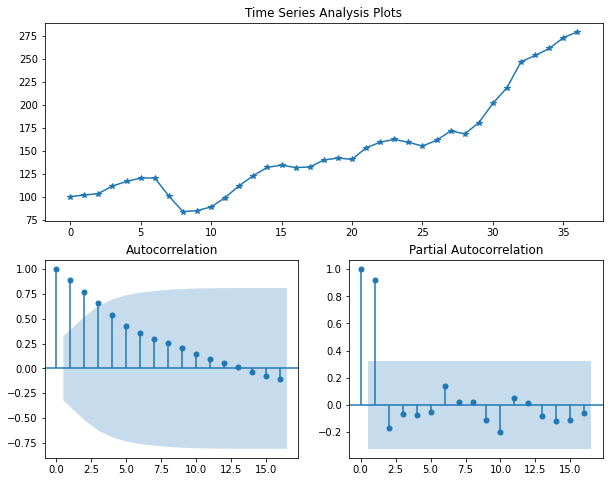

In [7]:
##read data
dfname='data1.14'
y=pd.read_csv('%s.csv'%dfname,header=None)
y.iloc[:,0]=y.iloc[:,0].astype('float')
y=y.values[:,0]
drawts(y,dfname)

## 1階差分

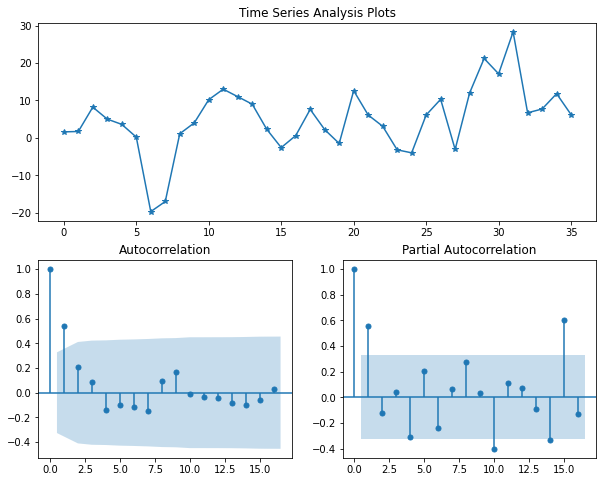

In [8]:
yd=y[1:]-y[:-1]
drawts(yd,dfname)

## 白噪聲檢驗

In [9]:
purerandtest(yd)

----time series: LB pure randomness test----
           LB    Pvalue  lags
0   11.304022  0.000773     1
1   13.038960  0.001474     2
2   13.376371  0.003890     3
3   14.241838  0.006562     4
4   14.693700  0.011755     5
5   15.330418  0.017837     6
6   16.360993  0.022015     7
7   16.764326  0.032659     8
8   18.155645  0.033410     9
9   18.162749  0.052280    10
10  18.216629  0.076688    11
11  18.330818  0.106009    12
12  18.751899  0.130999    13
13  19.383267  0.150815    14
14  19.626754  0.186723    15
15  19.675447  0.235195    16


/Users/shaohuasong/miniforge3/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
/Users/shaohuasong/miniforge3/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


## ARIMA(p,d,q)建模參數估計

In [10]:
##ARIMA
import statsmodels.tsa.arima.model as smt2
arma10=smt2.ARIMA(y,order=(0,1,1),trend='t').fit() #trend=n,c,t,ct
print('----fitting summary----')
print(arma10.summary())

----fitting summary----
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -122.987
Date:                Tue, 16 Nov 2021   AIC                            251.973
Time:                        22:36:40   BIC                            256.724
Sample:                             0   HQIC                           253.631
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.9955      2.030      2.461      0.014       1.017       8.974
ma.L1          0.6710      0.121      5.560      0.000       0.434       0.908
sigma2        53.4150     10

## 殘差白噪聲檢驗/模型顯著性檢驗

In [10]:
resid=arma10.resid
print('\n----residual pure randomness test')
purerandtest(resid)


----residual pure randomness test
----time series: LB pure randomness test----
          LB    Pvalue  lags
0   0.032855  0.856165     1
1   0.037206  0.981569     2
2   0.182875  0.980305     3
3   0.364757  0.985259     4
4   0.369261  0.996134     5
5   0.496676  0.997879     6
6   2.735159  0.908374     7
7   2.880708  0.941619     8
8   2.956030  0.966013     9
9   3.054958  0.980101    10
10  3.261388  0.986801    11
11  3.276563  0.993256    12
12  3.301899  0.996608    13
13  3.304265  0.998401    14
14  3.443359  0.999066    15
15  3.626610  0.999411    16


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:494: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


## 擬合

In [11]:
myalpha=0.05
mypred=arma10.get_prediction(start=0,end=len(y)-1,dynamic=False)  ##if True, start >0
print('\n----fitted confidence interval: %d %%'%((1-myalpha)*100))
print(mypred.summary_frame(alpha=myalpha))

#mypred.predicted_mean
#mypred.se_mean


----fitted confidence interval: 95 %
y         mean      mean_se  mean_ci_lower  mean_ci_upper
0     4.995491  1000.038733   -1955.044408    1965.035390
1   104.998896     8.801456      87.748360     122.249432
2   105.022829     7.802714      89.729791     120.315867
3   107.281212     7.507663      92.566464     121.995961
4   119.178269     7.394173     104.685956     133.670582
5   119.739665     7.346342     105.341098     134.138231
6   125.334807     7.325419     110.977249     139.692364
7   121.932510     7.316118     107.593182     136.271838
8    91.310265     7.311954      76.979099     105.641432
9    83.426462     7.310084      69.098961      97.753963
10   90.549719     7.309243      76.223866     104.875572
11   92.454503     7.308864      78.129393     106.779614
12  108.220263     7.308694      93.895486     122.545039
13  119.364620     7.308617     105.039994     133.689247
14  130.267805     7.308583     115.943247     144.592364
15  137.990739     7.308567     12

## 預測

In [12]:
step=10
phi=np.array([0,1])
theta=np.array([0,-0.6710])
myfuture=arima_pre(step,phi,theta,y,resid,arma10.params[-1])
print(myfuture)

         mean    mean_se  mean_ci_lower  mean_ci_upper
0  285.096569   7.308554     270.771803     299.421335
1  290.092069  14.232443     262.196482     317.987656
2  295.087569  18.753930     258.329867     331.845271
3  300.083069  22.379842     256.218579     343.947560
4  305.078569  25.495191     255.107994     355.049144
5  310.074069  28.269281     254.666279     365.481860
6  315.069569  30.794475     254.712398     375.426740
7  320.065069  33.127740     255.134699     384.995439
8  325.060569  35.307147     255.858562     394.262577
9  330.056069  37.359631     256.831191     403.280947


## 畫圖

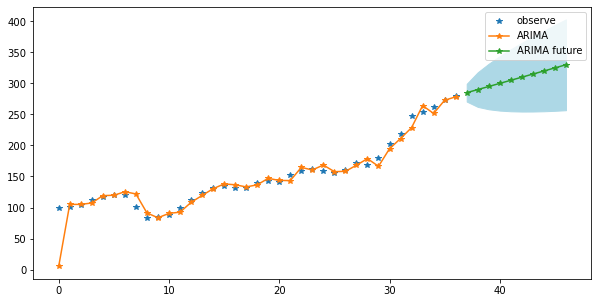

In [13]:
plt.figure(figsize=(10,5))
plt.plot(y,'*',label='observe')
plt.plot(mypred.predicted_mean,'-*',label='ARIMA')
plt.plot(np.arange(len(y),len(y)+myfuture.shape[0]),myfuture['mean'].values,'-*',label='ARIMA future')

plt.fill_between(np.arange(len(y),len(y)+myfuture.shape[0]),
                 myfuture['mean_ci_lower'].values,
                 myfuture['mean_ci_upper'].values,
                 color='lightblue')
plt.legend()
plt.show()